In [2]:
# /// script
# dependencies = [
# "scipy",
# "numpy",
# "matplotlib",
# "pandas",
# "openpyxl",
# "nptyping",
# ]
# ///
# AS PER PYTHON STYLE GUIDES FOR REQUIRED PACKAGES ^

import scipy as sp
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from copy import deepcopy
from nptyping import NDArray

# Specific fxns, ect.
from scipy.stats import linregress
from matplotlib.lines import Line2D

In [3]:
# KNOWN DATA -- UPDATE AS NEEDED

RPMS = [400, 900, 1600, 2500]

class Electrolyte():
    """
    Wrapper class for electrolyte data
    """

    def __init__(self, conc, kin_visc, t_p, DAT) -> None:
        self.conc = conc # MOLAR
        self.kin_visc = kin_visc # CM^2 / S
        self.t_p = t_p # UNITLESS
        self.data = {}
        self.diffusivity = None

        if isinstance(DAT, str):
            for i in range(4):
                self.data[RPMS[i]] = pd.read_excel(DAT, i)

        else:
            self.data = DAT

# Initialize electrolyte data

E1 = Electrolyte(1, 0.025, 0.36, "Electrolyte1_RDE_data.xlsx")
E2 = Electrolyte(4, 0.1, 0.55, "Electrolyte2_RDE_data.xlsx")
E3 = Electrolyte(1, 0.2, 0.25, "Electrolyte3_RDE_data.xlsx")

data = [E1, E2, E3]
E1.data[400].head()


,V (mV),Current Density (mA/cm2)
0,0.000000,5.781907
1,1.101101,5.554195
2,2.202202,5.596112
3,3.303303,5.745230
4,4.404404,5.652301


## 1a

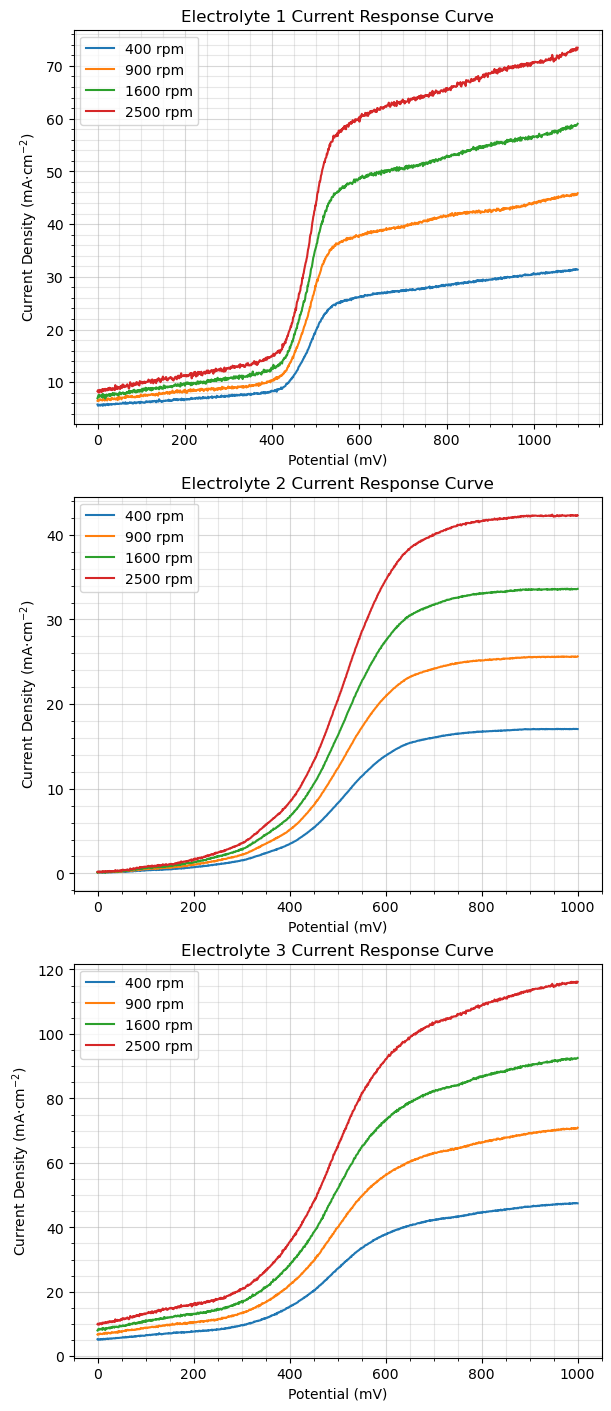

In [4]:
fig, axes = plt.subplots(3, 1, layout='constrained', figsize=(6,14))

for idx, ax in enumerate(axes):
    electrolyte = data[idx]
    ax.set_title(f'Electrolyte {idx+1} Current Response Curve')
    for rpm in electrolyte.data.keys():
        ax.plot(electrolyte.data[rpm]['V (mV)'], electrolyte.data[rpm]['Current Density (mA/cm2)'], label=f'{rpm} rpm')
    ax.set_ylabel(r"Current Density (mA$\cdot$cm$^{-2}$)")
    ax.set_xlabel("Potential (mV)")
    ax.minorticks_on()
    ax.grid(which='both', alpha=0.3)
    ax.grid(which='major', alpha=0.5)
    ax.legend()

## 1b

In [5]:
def linfit_range(data, minV, maxV):

    data_in_range = data[data['V (mV)'].between(minV, maxV)]

    voltages = data_in_range['V (mV)']
    currents = data_in_range['Current Density (mA/cm2)']

    return linregress(voltages, currents)
    

## 1c

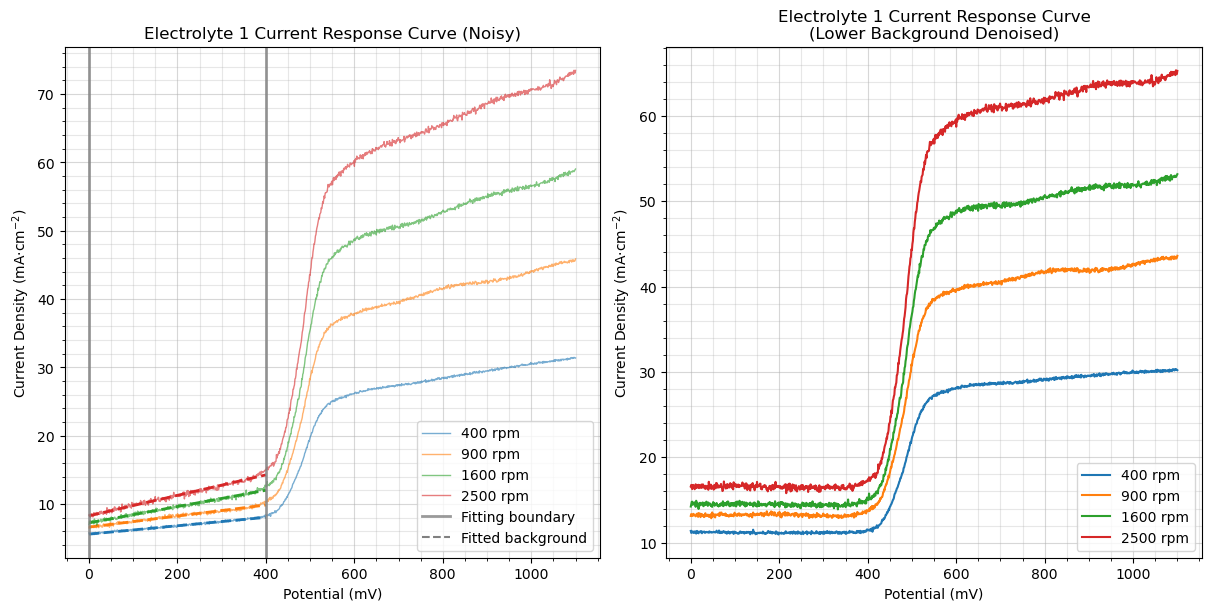

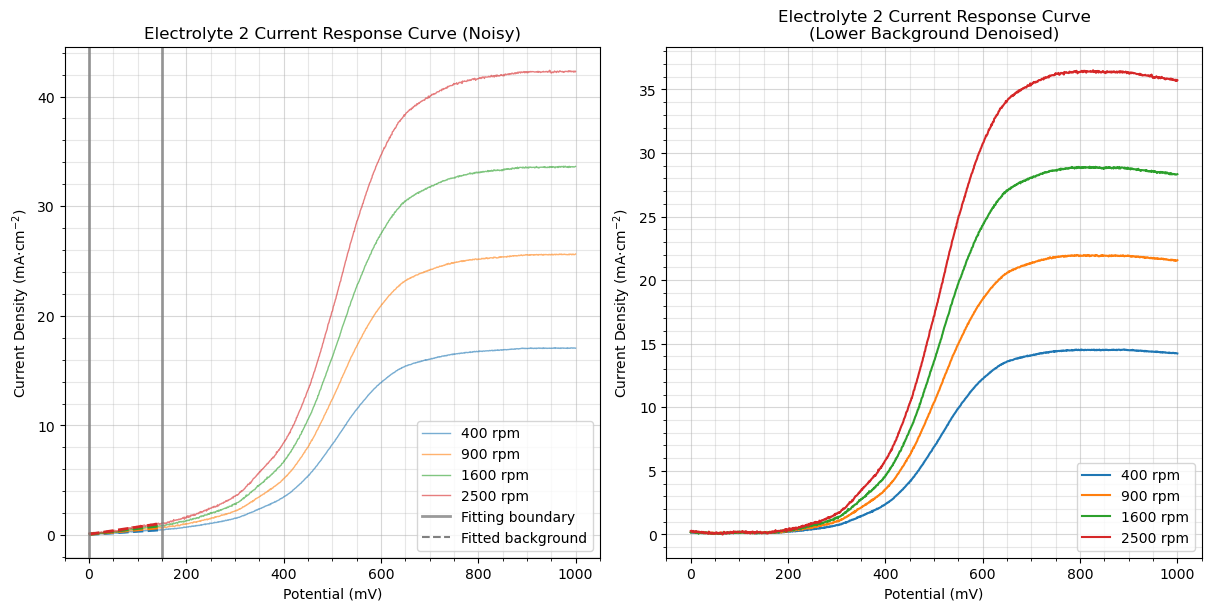

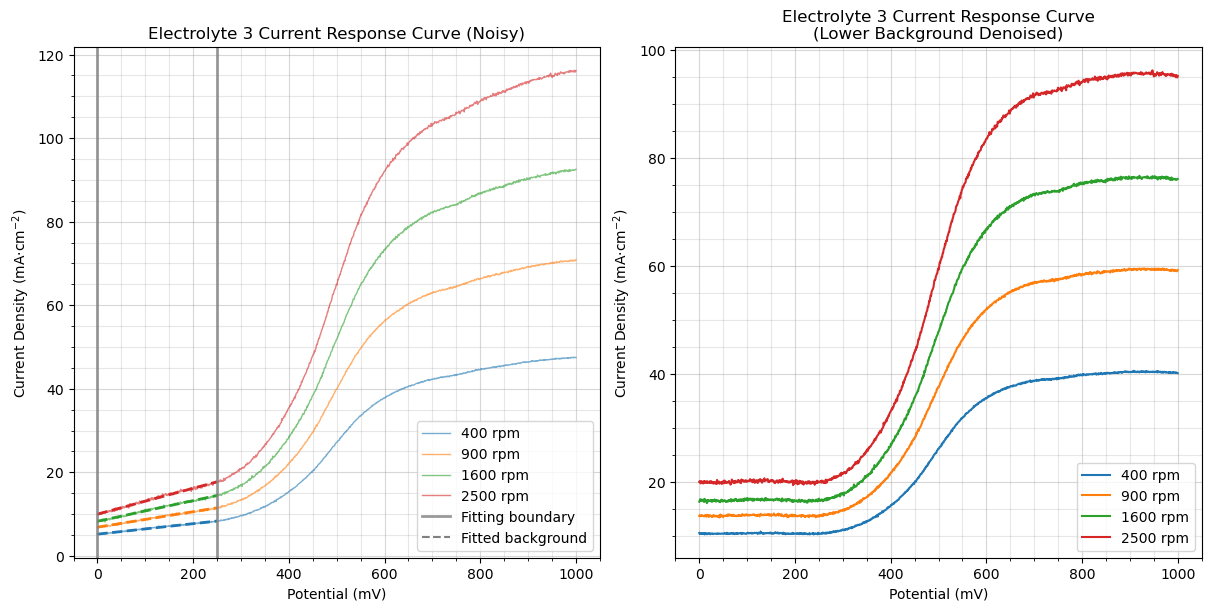

In [6]:
# Subtract background

def subtract_bgnd(electrolyte, idx, minV, maxV, graph=True):
    if graph == True:
        fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', figsize=(12, 6))

    regressions = []
    out = {}
    for rpm in RPMS:
        data = electrolyte.data[rpm].copy(deep=True)

        regress = linfit_range(data, minV, maxV)
        regressions.append(regress)

        delta_fxn = lambda x, y: y - regress.slope*x + regress.intercept

        if graph == True:
            ax1.set_title(f'Electrolyte {idx} Current Response Curve (Noisy)')
            ax1.plot(data['V (mV)'], data['Current Density (mA/cm2)'], label=f'{rpm} rpm', alpha=0.6, linewidth=1)
            regress_range = np.linspace(minV, maxV, 1000)
            ax1.plot(regress_range, [regress.slope*x + regress.intercept for x in regress_range],
                     color=ax1.lines[-1].get_color(),
                     ls='--',
                     linewidth=2
                     )
            ax1.set_ylabel(r"Current Density (mA$\cdot$cm$^{-2}$)")
            ax1.set_xlabel("Potential (mV)")
            ax1.minorticks_on()
            ax1.grid(which='both', alpha=0.3)
            ax1.grid(which='major', alpha=0.5)

        # Change data and graph changed data
        data['Current Density (mA/cm2)'] = list(map(delta_fxn, data['V (mV)'], data['Current Density (mA/cm2)']))

        if graph == True:
            ax2.set_title(f'Electrolyte {idx} Current Response Curve\n(Lower Background Denoised)')
            ax2.plot(data['V (mV)'], data['Current Density (mA/cm2)'], label=f'{rpm} rpm')
            ax2.set_ylabel(r"Current Density (mA$\cdot$cm$^{-2}$)")
            ax2.set_xlabel("Potential (mV)")
            ax2.minorticks_on()
            ax2.grid(which='both', alpha=0.3)
            ax2.grid(which='major', alpha=0.5)
            ax2.legend(loc='lower right')
        
        out[rpm] = data

    if graph==True:
        ax1.axvline(minV, color="gray", label='Fitting boundary', alpha=0.8, linewidth=2)
        ax1.axvline(maxV, color="gray", alpha=0.8, linewidth=2)
        handles, labels = ax1.get_legend_handles_labels()
        handles.append(Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5))
        labels.append('Fitted background')
        ax1.legend(handles=handles, labels=labels)
        plt.show(fig)
    
    adjusted_electrolyte = Electrolyte(
        electrolyte.conc,
        electrolyte.kin_visc,
        electrolyte.t_p,
        out
    )

    return adjusted_electrolyte, regressions

E1_base, E1_lowerfit = subtract_bgnd(E1, 1, 0, 400)
E2_base, E2_lowerfit = subtract_bgnd(E2, 2, 0, 150)
E3_base, E3_lowerfit = subtract_bgnd(E3, 3, 0, 250)

lowerfits = E1_lowerfit + E2_lowerfit + E3_lowerfit


## 1d

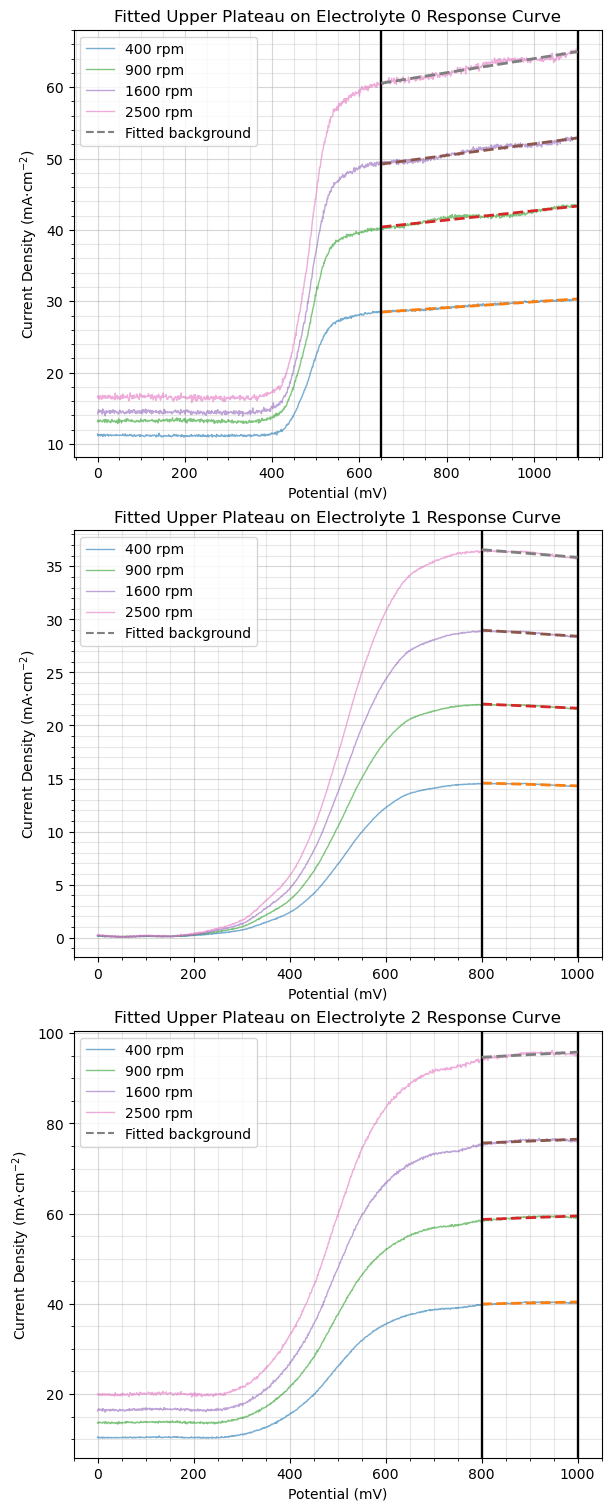

In [36]:
corrected_data = [E1_base, E2_base, E3_base]

start_end = [
    (650, 1100),
    (800, 1000),
    (800, 1000)
]

fitted_uppers = []

fig, axes = plt.subplots(3, 1, figsize=(6, 15), layout='constrained')
for i, e in enumerate(corrected_data):
    for rpm in RPMS:
        # Find upper bound
        axes[i].set_title(f'Fitted Upper Plateau on Electrolyte {i} Response Curve')
        axes[i].set_ylabel(r"Current Density (mA$\cdot$cm$^{-2}$)")
        axes[i].set_xlabel("Potential (mV)")
        
        cdata = corrected_data[i].data[rpm]
        start = start_end[i][0]
        end = start_end[i][1]

        upper_fit = linfit_range(cdata, start, end)
        fitted_uppers.append(upper_fit)
        axes[i].plot(cdata['V (mV)'], cdata['Current Density (mA/cm2)'], label=f'{rpm} rpm', alpha=0.6, linewidth=1)
        N = np.linspace(start, end, 1000)
        axes[i].axvline(start, color='black')
        axes[i].axvline(end, color='black')
        axes[i].plot(N, [upper_fit.slope*n + upper_fit.intercept for n in N], ls='--', linewidth=2)
        axes[i].minorticks_on()
        axes[i].grid(which='both', alpha=0.3)
        axes[i].grid(which='major', alpha=0.5)
        handles, labels = axes[i].get_legend_handles_labels()
        handles.append(Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5))
        labels.append('Fitted background')
        axes[i].legend(handles=handles, labels=labels)


## 1e

INFLECTION POINTS
------------------------
[479.12605106 480.20036912 480.32152027 480.50795316 515.19819325
 513.11359872 512.53509084 513.35258125 501.24648647 489.37126837
 489.86335705 487.51852375]


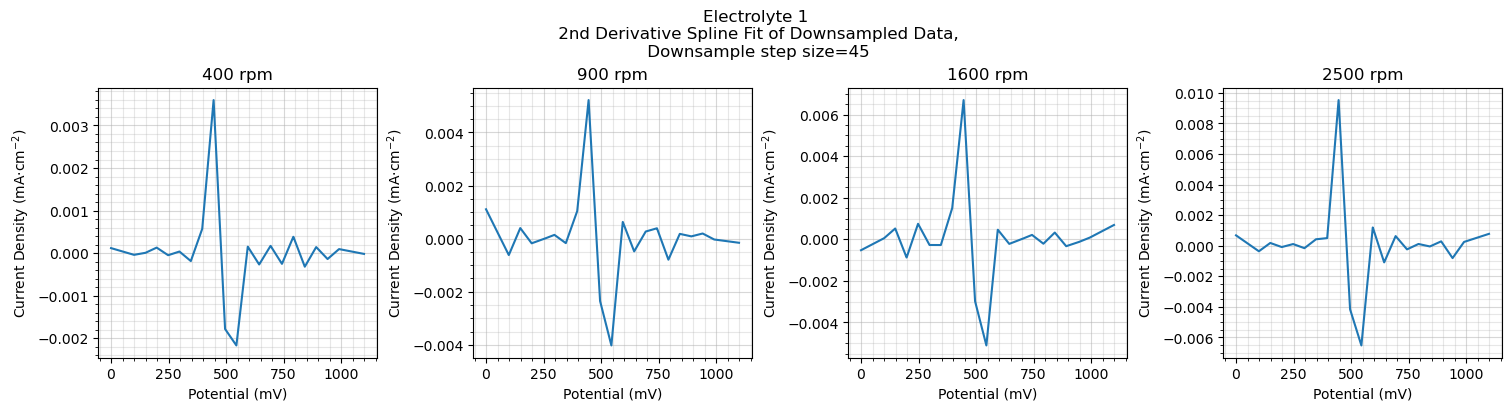

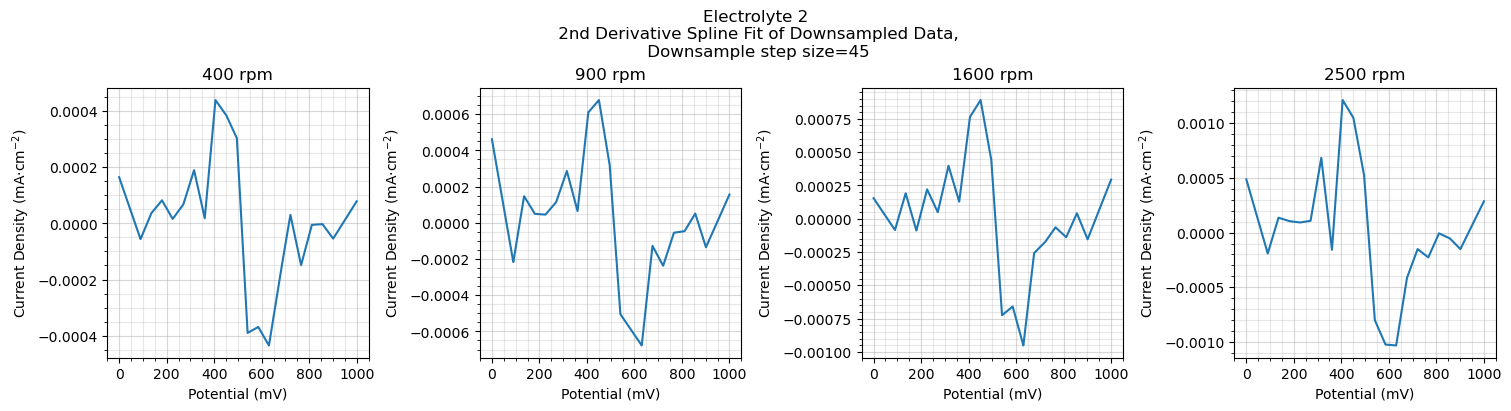

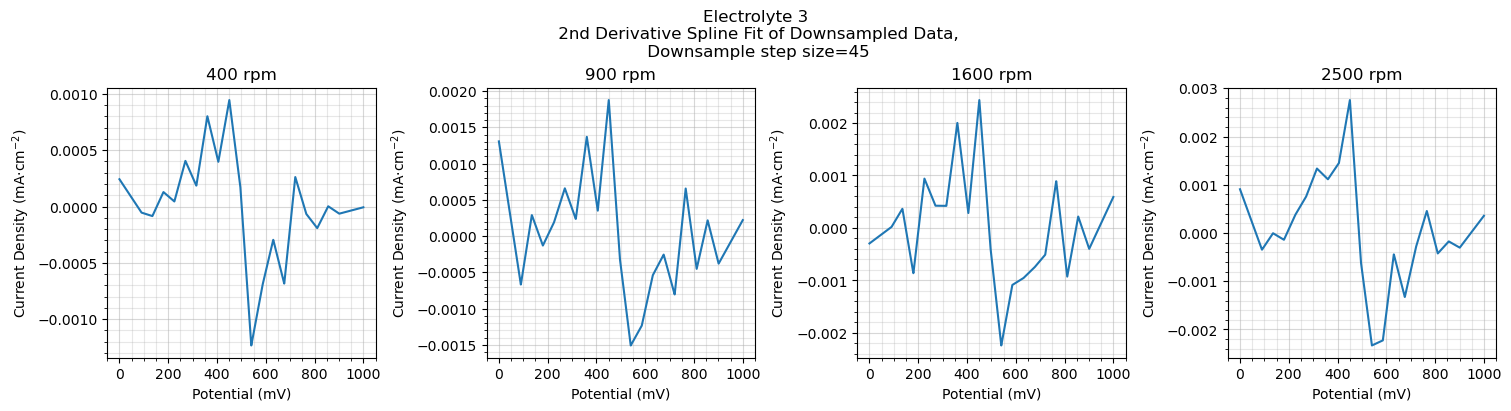

In [37]:
from scipy.optimize import newton

def pt_inflec(electrolyte, guess, index):
    fig, axes = plt.subplots(1, 4, layout='constrained', figsize=(15, 4))
    fig.suptitle(f'Electrolyte {index}\n 2nd Derivative Spline Fit of Downsampled Data,\n Downsample step size=45')

    zeros = []
    for idx, rpm in enumerate(RPMS):
        x_reduced = electrolyte.data[rpm]['V (mV)'][::45]
        y_reduced = electrolyte.data[rpm]['Current Density (mA/cm2)'][::45]

        spline_dxdx = sp.interpolate.make_interp_spline(x_reduced, y_reduced).derivative().derivative()

        N = np.linspace(0, max(electrolyte.data[rpm]['V (mV)']), 3000)
        axes[idx].set_title(f'{rpm} rpm')
        axes[idx].plot(N, [spline_dxdx(n) for n in N])
        

        axes[idx].set_ylabel(r"Current Density (mA$\cdot$cm$^{-2}$)")
        axes[idx].set_xlabel("Potential (mV)")
        axes[idx].minorticks_on()
        axes[idx].grid(which='both', alpha=0.3)
        axes[idx].grid(which='major', alpha=0.5)
        
        # Predict zero
        zeros.append(newton(spline_dxdx, guess))
    return zeros

guesses = [475, 510, 500]
print("INFLECTION POINTS\n------------------------")
inflec_pts = []
for i, e in enumerate(corrected_data):
    inflec_pts.append(pt_inflec(e, guesses[i], i+1))
inflec_pts = np.array(inflec_pts).flatten()
print(inflec_pts)

## 1f

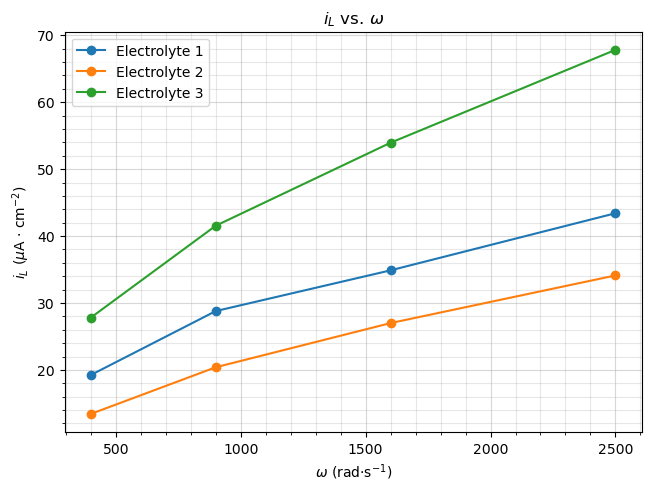

In [38]:
def calc_IL(basefit, endfit, inflec) -> float:
    lower_at_inflec = basefit.slope*inflec + basefit.intercept
    upper_at_inflec = endfit.slope*inflec + endfit.intercept

    I_F = upper_at_inflec - lower_at_inflec

    return I_F

ILS = []
minV = [0, 0, 0]
maxV = [400, 150, 250]
for i in range(len(fitted_uppers)):
    ILS.append(
        calc_IL(
        lowerfits[i],
        fitted_uppers[i],
        inflec_pts[i]
        )
    )

# Graph I_L as a function of angular velocity

fig, ax = plt.subplots(layout='constrained')

ax.set_title(r"$i_L$ vs. $\omega$")

ax.set_ylabel(r"$i_L$ ($\mu$A $\cdot$ cm$^{-2}$)")
ax.set_xlabel(r"$\omega$ (rad$\cdot$s$^{-1}$)")

set1 = ILS[:4]
set2 = ILS[4:8]
set3 = ILS[8:]

combined = [set1, set2, set3]

ax.plot(RPMS, set1, marker='o', label='Electrolyte 1')
ax.plot(RPMS, set2, marker='o', label='Electrolyte 2')
ax.plot(RPMS, set3, marker='o', label='Electrolyte 3')

#ax.set_xlim(1979, 2024)
#ax.set_ylim(1.8, 2.1)
ax.minorticks_on()
ax.grid(which='both', alpha=0.3)
ax.grid(which='major', alpha=0.5)
ax.legend(loc='best');

## 1g

/var/folders/5d/8ff_82ys5wx23f2vrm8f7rw00000gn/T/ipykernel_5160/4021616395.py:14: RuntimeWarning: invalid value encountered in scalar power
  * D**(2/3)


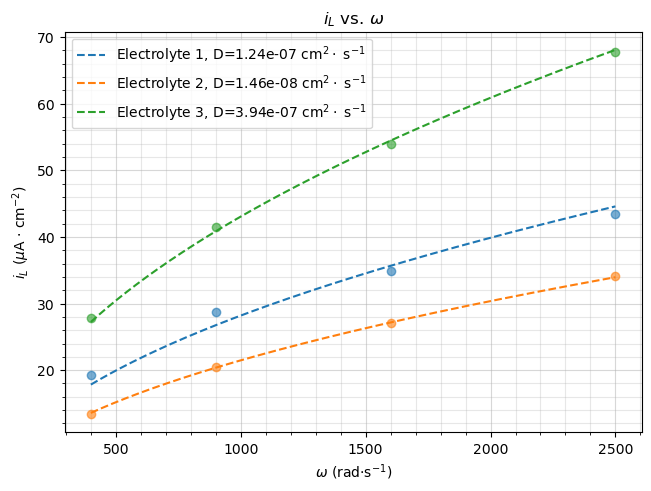

In [39]:
from scipy.optimize import curve_fit

def levich(rpm, D, v, C):

    omega = rpm * (2 * np.pi / 60)

    F = 9.64853321e10 # in microamps

    c_cm3 = C / 1000

    output = (
        0.620
        * F
        * D**(2/3)
        * omega**(1/2)
        * v**(-1/6)
        * c_cm3/1000
    )

    return output

fig, ax = plt.subplots(layout='constrained')

ax.set_title(r"$i_L$ vs. $\omega$")

ax.set_ylabel(r"$i_L$ ($\mu$A $\cdot$ cm$^{-2}$)")
ax.set_xlabel(r"$\omega$ (rad$\cdot$s$^{-1}$)")


ax.plot(RPMS, set1, marker='o', alpha=0.6, ls='')
ax.plot(RPMS, set2, marker='o', alpha=0.6, ls='')
ax.plot(RPMS, set3, marker='o', alpha=0.6, ls='')


ax.minorticks_on()
ax.grid(which='both', alpha=0.3)
ax.grid(which='major', alpha=0.5)

X = np.linspace(400, 2500, 3000)
for idx, e in enumerate(data):
    levich_fxn = lambda omega, D: levich(omega, D, e.kin_visc, e.conc)
    popt, pcov = curve_fit(levich_fxn, RPMS, combined[idx])
    e.diffusivity = popt[0]
    ax.plot(X, [levich(omega, popt, e.kin_visc, e.conc) for omega in X], ls='--', color=ax.lines[idx].get_color(), label=fr'Electrolyte {idx+1}, D={popt[0]:.3g} cm$^2\cdot$ s$^{{{-1}}}$')

ax.legend();
    

## 1h
0.620 should be dimensionless, as the other units make the desired $\mu A\cdot cm^{-2}$

## QUESTION 2

## 2a

## 2b

In [40]:
def gen_coeff(dt, dx, n_spatial, diffusivity) -> NDArray:
    """
    :param dt: Size of time step
    :param dx: Size of spatial step
    :param n_spatial: # of simulated spatial points (including boundaries)
    :param diffusivity: diffusivity constant of the electrolyte
    """

    R = diffusivity*dt / dx**2
    
    # Generate output sparse mat
    MAT = np.zeros((n_spatial, n_spatial))

    for i in range(n_spatial):
        MAT[i, i] = (2*R + 1)

        if i==0:
            # Initial boundary condition.
            MAT[i, i+1] = -2*R
        elif i == (n_spatial-1):
            # Middle boundary condition
            MAT[i, i] = 1
        else:
            MAT[i, i-1] = -R
            MAT[i, i+1] = -R
    
    return MAT

def gen_constvec(dt,
                 dx,
                 n_spatial,
                 init_concentration,
                 cur_density,
                 t_p,
                 prev_sol=None) -> NDArray:
    """
    :param dt: Size of time step
    :param dx: Size of spatial step
    :param n_spatial: # of simulated spatial points (including boundaries)
    :param init_concentration: Initial concentration of cell
    :param t_p: transference number
    :param cur_density: current density
    :param prev_sol: the values of the functions at the previous timestep.
    If no vector is passed, then we assume a uniform spatial init_concentration
    """
    if not isinstance(prev_sol, NDArray):
        # Assume previous coefficients are previous iteration
        prev_sol = np.full((n_spatial), init_concentration)
    else:
        # Guarantee that we have correct shape
        assert prev_sol.shape[0] == (n_spatial)
    
    F = 9.64853321e4

    A = (1-t_p) * cur_density/F
    END_CONST = 2*dt*A / dx

    VEC = prev_sol.copy()

    # Initial condition
    VEC[0] += END_CONST

    # Middle condition
    VEC[-1] = init_concentration

    return VEC


## 2c

In [41]:
def next_concentration(dt,
                       dx,
                       n_spatial,
                       init_concentration,
                       diffusivity,
                       cur_density,
                       t_p,
                       prev_sol=None) -> NDArray:
    """
    :param dt: Size of time step
    :param dx: Size of spatial step
    :param n_spatial: # of simulated spatial points (including boundaries)
    :param init_concentration: Initial concentration of cell
    :param diffusivity: diffusivity constant of the electrolyte
    :param t_p: transference number
    :param cur_density: current density
    :param prev_sol: the values of the functions at the previous timestep.
    If no vector is passed, then we assume a uniform spatial init_concentration
    """
    VEC = gen_constvec(dt, dx, n_spatial, init_concentration, cur_density, t_p, prev_sol)
    MAT = gen_coeff(dt, dx, n_spatial, diffusivity)

    return np.linalg.solve(MAT, VEC)

## 2d

In [13]:
def solve_electrolyte(L, dt, T, e: Electrolyte, cur_density, n_spatial=100) -> NDArray:
    """
    NOTE: If T=None, then we just go until Sand's Time
    """

    if isinstance(T, float) or isinstance(T, int):
        # Define out output solutions vector:
        timesteps = int(T // dt)
        dx = L / (2*n_spatial)

        OUT = np.empty((timesteps+1, n_spatial)) # output array

        init_conc_mM = e.conc / 1000 # Convert to cm^-3

        SOL = np.full((n_spatial), init_conc_mM)
        OUT[0] = SOL

        for t in range(timesteps):
            SOL = next_concentration(dt, dx, n_spatial, init_conc_mM, e.diffusivity, cur_density, e.t_p, SOL)
            OUT[t+1] = SOL
    else:
        dx = L / (2*n_spatial)
        OUT = np.empty((n_spatial))
        init_conc_mM = e.conc / 1000 # Convert to cm^-3
        SOL = np.full((n_spatial), init_conc_mM)
        OUT = SOL

        while True:
            SOL = next_concentration(dt, dx, n_spatial, init_conc_mM, e.diffusivity, cur_density, e.t_p, SOL)
            OUT = np.vstack((OUT, SOL))
            if SOL[0] >= 2*init_conc_mM:
                # We have found sand's time. Stop.
                break

    return OUT


## 2e

Example: Running on electrolyte E3:

In [14]:
# Lets run this thingggg
T=100
L=50e-4 # in cm
dt=0.01

out_data = solve_electrolyte(
    L=L, # Centemeters
    dt=dt,
    T=T,
    e=E3,
    cur_density=1,
    n_spatial=100
)

## 2f

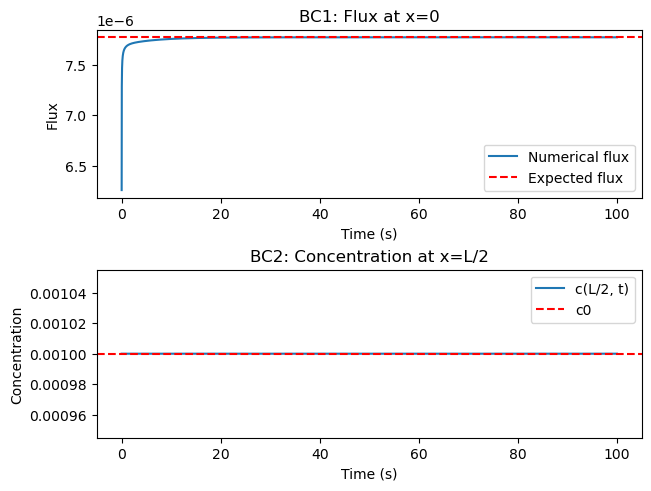

In [15]:
def plot_bc_verification(out_data, dx, D, t_p, i, c0, dt):
    F = 9.64853321e4
    times = np.arange(len(out_data)) * dt
    expected_flux = (1 - t_p) * i / F

    numerical_flux = -D * (out_data[:, 1] - out_data[:, 0]) / dx

    fig, (ax1, ax2) = plt.subplots(2, 1, layout='constrained')
    
    ax1.plot(times, numerical_flux, label='Numerical flux')
    ax1.axhline(expected_flux, color='r', ls='--', label='Expected flux')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Flux')
    ax1.set_title('BC1: Flux at x=0')
    ax1.legend()

    ax2.plot(times, out_data[:, -1], label='c(L/2, t)')
    ax2.axhline(c0, color='r', ls='--', label='c0')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Concentration')
    ax2.set_title('BC2: Concentration at x=L/2')
    ax2.legend()

plot_bc_verification(out_data[1:], L/200, E3.diffusivity, E3.t_p, 1, E3.conc/1000, dt)

### NOTE:
Here I'm using a forward difference approximation to approximate the derivative at the x=0 boundary, which isn't perfect. Since we initialize the ENTIRE cell to a flat value at the start and THEN enforce that the flux must be a nonzero constant at x=0, this naturally forces the function to have a LOT of curvature at low time steps. Thus, I think the reason we see this sharp increase at low timesteps is not because the calculation is incorrect (I show here that it obviously converges to the expected value as time goes on), but perhaps there is a lot of curvature to our function at first.

## 2g

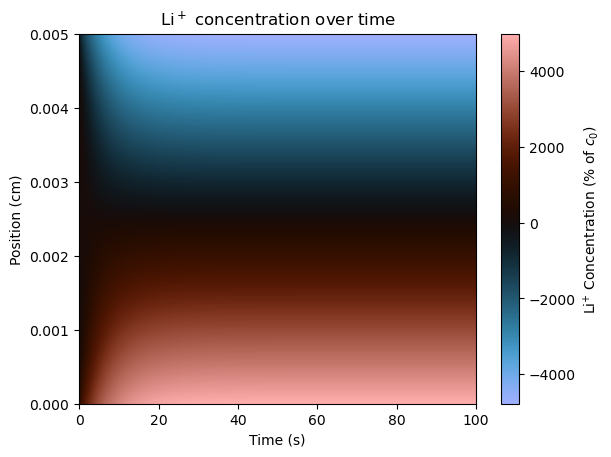

In [42]:
def create_plot(time_data, T, L):

    # Create other half of battery
    initial_conc = time_data[0,0]
    recieving_half = initial_conc - (np.fliplr(time_data) - initial_conc)

    time_data = np.hstack((time_data, recieving_half[:, 1:])) # Remove first column that is duplicated
    time_data = time_data / initial_conc * 100


    fig, ax = plt.subplots()

    im = ax.imshow(
        time_data.T,
        aspect='auto',
        origin='lower',
        extent=[
            0, T, 0, L
        ],
        cmap='berlin'
    )

    plt.colorbar(im, ax=ax, label=r'Li$^{+}$ Concentration (% of $c_0$)')
    ax.set_title("Li$^+$ concentration over time")
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position (cm)')

create_plot(out_data, T, L)

NOTE THAT THIS IS UNPHYSICAL--OBVIOUSLY WE CAN'T GO BENEATH ZERO CONCENTRATION!! JUST TO DEMONSTRATE THE GRAPH

## 2i

[0.002945701259268149, 0.014233569617077835, 0.005332534882641127]


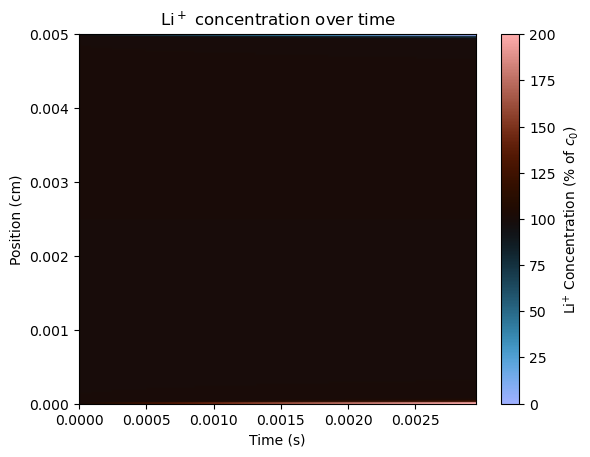

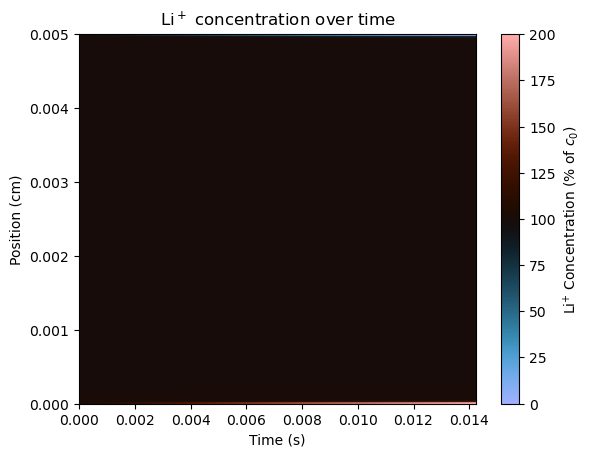

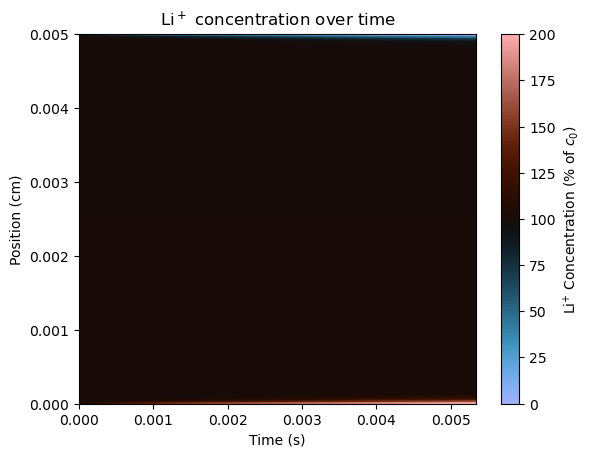

In [43]:
def st_analytical(D, c0, t_p, i):
    F = 9.64853321e4
    return (
        np.pi / 4
        * D
        * (
            (F*c0)
            / ((1-t_p)*i)
        )**2
    )

analytical_st = []
for e in data:
    # Calculate the analytical times
    analytical_st.append(st_analytical(
        e.diffusivity, e.conc/1000, e.t_p, 1
    ))

# Determine what these should be in using our numerical model

numerical_st =[]


L = 50e-4
dt = 0.00001
for e in data:
    # Solve until we get to double our initial value
    out = solve_electrolyte(L, dt, None, e, 1, 100)
    
    # Get the time step that the zero sand's time is in between
    lower_bound = out[-2, 0]
    upper_bound = out[-1, 0]

    # Determine the corresponding time steps
    lower_time = dt*(out.shape[0]-2)
    upper_time = dt*(out.shape[0]-1)

    create_plot(out, upper_time, L)

    c_target = 2*e.conc / 1000

    # linearly extrapolate to guess where the zero is
    zero = lower_time + (c_target - lower_bound) * (upper_time-lower_time)/(upper_bound-lower_bound)
    numerical_st.append(zero)

print(numerical_st)


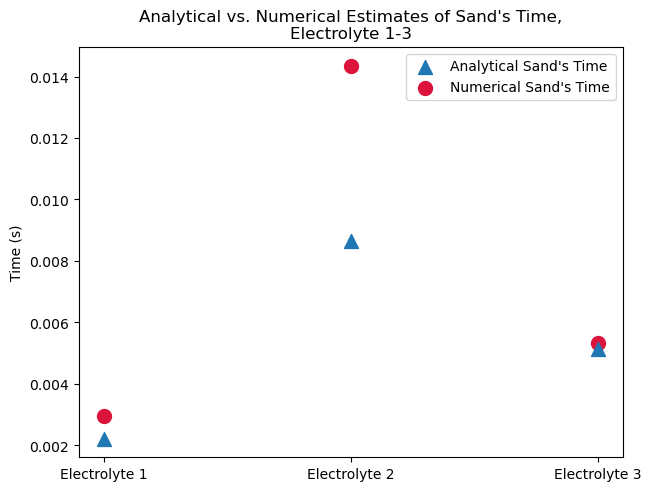

In [ ]:
# Graph differences

fig, ax = plt.subplots(layout='constrained')

labels = ['Electrolyte 1', 'Electrolyte 2', 'Electrolyte 3']

x = np.arange(len(labels))

ax.scatter(x, analytical_st, s=100, marker='^', label="Analytical Sand's Time")

ax.scatter(x, numerical_st, color='crimson', s=100, label="Numerical Sand's Time", zorder=0)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title("Analytical vs. Numerical Estimates of Sand's Time,\nElectrolyte 1-3")
ax.set_ylabel("Time (s)")
ax.legend();


The pattern here is clear that our numerical approximation does indeed provide at least a qualitative approximation of the actual sand's time that was found analytically. Electrolytes 1 and 2's numerical predictions were extremeley close to those predicted analytically. While the second electrolyte's estimate deviated significantly from its analytically predicted value, it was sucessful in predicting at least qualitativly that Sand's Time should be higher than the other two electrolytes for the second electrolyte.

Since both models are presumptivly highly approximated, it would be harder to draw any more quantitative conclusions from these results, especially considering that no repeat expiraments were conducted. It is interesting to note that electrolyte 2's fit to the Levich equation was actually better than the first electrolyte's, yet the first electrolyte is much better predicted by the analytical model. As noted, both models are highly approximated, but one theory as to why this may be the case is due to the analytical model's deviation from actual electrolytes with more diffuse electrolytes. This could also be an artifact of the extremely high current 'applied' to the batteries in our simulation, which causes dendrites to begin to form within a tenth of a second.

## 2j

It is apparent from the results above that Electrolyte 2 has the highest Sand's time, indicating that a Li-metal battery made using Electrolyte 2 would survive more charge/discharge cycles before the growth of dendrites dominates. While this is indeed a marker for the robustness of the marker, we must also consider that the precise reasons why Electrolyte 2 is more durable--namely, its lower charge density